In [1]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Poisson_Model_T
%matplotlib inline


%load_ext autoreload
%autoreload 2

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('../data/gp_weekly_grid_parkslope.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
e_s = (5.36 / data.GRID_SQUARE.max()) # 5.36 is 2016 mean weekly crashes in park slope, divide by # squares
print(e_s)

0.111666666667


In [3]:
search_periods = [
                 [5,12],
                 [6,12],
                 [8,12]]
                 




Beginning run [5, 12] : 
Training ends on: 2017-02-05 00:00:00
testing ends on: 2017-04-30 00:00:00
Initial neg. log-likelihood: -526.705389586
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 249.160898
  Number of iterations: 370
  Number of functions evaluations: 397
added gp pred and error to test
gp_sq_error    0.786859
0              1.366987
dtype: float64
Beginning run [6, 12] : 
Training ends on: 2017-02-12 00:00:00
testing ends on: 2017-05-07 00:00:00
Initial neg. log-likelihood: -621.989697275
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 289.023624
  Number of iterations: 367
  Number of functions evaluations: 395
added gp pred and error to test
gp_sq_error    0.899038
0              0.858974
dtype: float64
Beginning run [8, 12] : 
Training ends on: 2017-02-26 00:00:00
testing ends on: 2017-05-21 00:

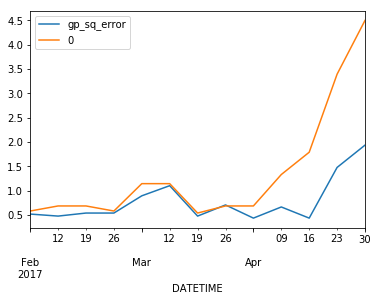

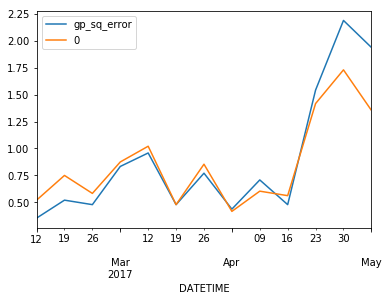

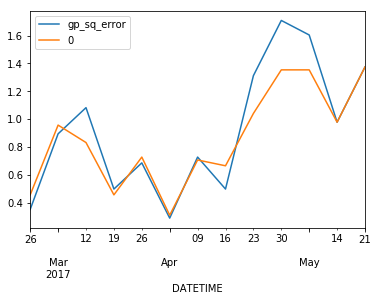

In [5]:
for i, s in enumerate(search_periods):
    
    
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2017/01/01', training_end_date= s[0], \
                                                           testing_end_date=s[1])

    m = Poisson_Model_T(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= e_s, period = 52)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 1000)
    
    u.pred_GP(m,data_dict)
    
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


In [ ]:
test.groupby('DATETIME')[['gp_pred','COUNT']].sum().plot()

In [ ]:
test.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

In [ ]:
test[test.GRID_SQUARE == 33][['gp_pred','COUNT']]